In [1]:
# rm(list = ls())
library(dplyr)
library(stringr)
library(forcats)
library(ggplot2)
library(ggsci)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
nov = '../data/human/transcript_novelties.tsv'
cerb_ids = '../data/human/suppa/gtex/cerb_ids.tsv'
psi = '../data/human/cerberus_psi.tsv'
lr_meta = '../ref/human/lr_human_library_data_summary.tsv'
c_s_al_events = '../data/human/suppa/AL_combined.tsv'
c_s_af_events = '../data/human/suppa/AF_combined.tsv'

af = '../data/human/suppa/cerberus.events_AF_strict.ioe'
a3 = '../data/human/suppa/cerberus.events_A3_strict.ioe'
a5 = '../data/human/suppa/cerberus.events_A5_strict.ioe'
al = '../data/human/suppa/cerberus.events_AL_strict.ioe'
ri = '../data/human/suppa/cerberus.events_RI_strict.ioe'
mx = '../data/human/suppa/cerberus.events_MX_strict.ioe'
se = '../data/human/suppa/cerberus.events_SE_strict.ioe'

g_af = '../data/human/suppa/gtex/cerberus.events_AF_strict.ioe'
g_a3 = '../data/human/suppa/gtex/cerberus.events_A3_strict.ioe'
g_a5 = '../data/human/suppa/gtex/cerberus.events_A5_strict.ioe'
g_al = '../data/human/suppa/gtex/cerberus.events_AL_strict.ioe'
g_ri = '../data/human/suppa/gtex/cerberus.events_RI_strict.ioe'
g_mx = '../data/human/suppa/gtex/cerberus.events_MX_strict.ioe'
g_se = '../data/human/suppa/gtex/cerberus.events_SE_strict.ioe'

## Proportion of novel transcripts per event

In [3]:
## using new transcript table
transcripts <- read.table(nov, sep = '\t', header = T, check.names = F, comment.char = '')
transcripts <- transcripts %>% filter(source == 'lapa') %>% unique()
transcripts$transcript_id <- gsub(',','_', transcripts$transcript_id)

In [4]:
AF <- read.table(af, header = T)
events <- unlist(lapply(AF$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
AF <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'AF')

A3 <- read.table(a3, header = T)
events <- unlist(lapply(A3$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
A3 <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'A3')

A5 <- read.table(a5, header = T)
events <- unlist(lapply(A5$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
A5 <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'A5')

AL <- read.table(al, header = T)
events <- unlist(lapply(AL$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
AL <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'AL')

MX <- read.table(mx, header = T)
events <- unlist(lapply(MX$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
MX <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'MX')

RI <- read.table(ri, header = T)
events <- unlist(lapply(RI$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
RI <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'RI')

SE <- read.table(se, header = T)
events <- unlist(lapply(SE$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
SE <- subset(transcripts, transcripts$transcript_id %in% events) %>% mutate(event = 'SE')

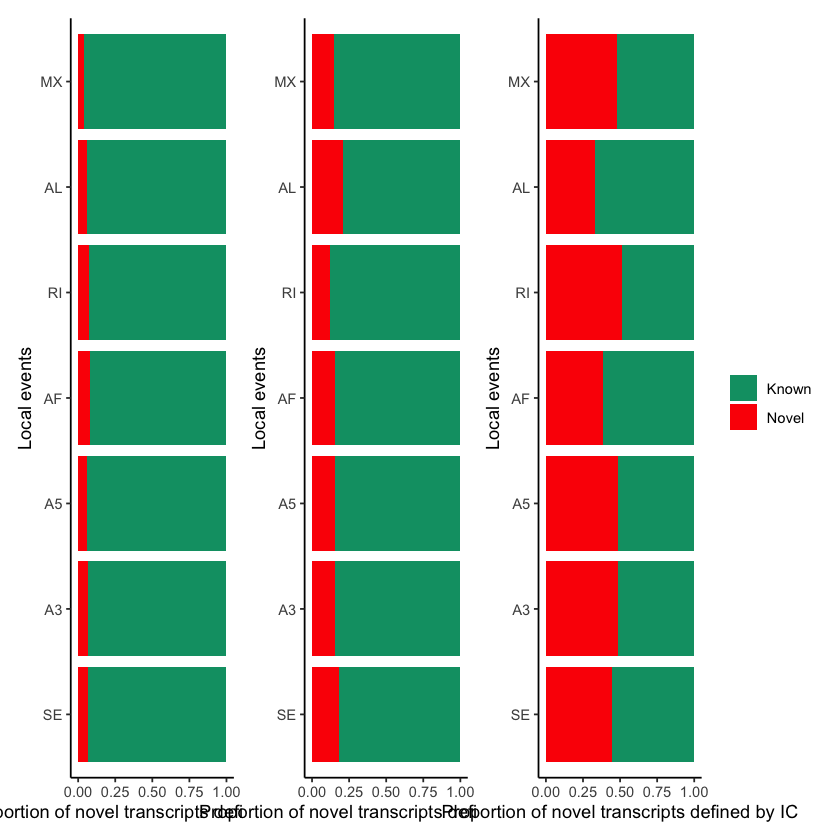

In [5]:
cols <- c('Known' = '#009E73', 'Novel' = '#fc2003')

tss <- rbind(A3, A5, AF, AL, MX, RI, SE) %>% 
  select(transcript_id, type = tss_novelty, event) %>%
  distinct(transcript_id, type, event,.keep_all = TRUE) %>%
  ggplot(aes(x = fct_infreq(event), fill = type)) + geom_bar(position = 'fill') +  scale_fill_manual(values = cols)  +
  coord_flip() + labs(x = 'Local events', y = 'Proportion of novel transcripts defined by TSS') + theme_classic() +
  theme(legend.title=element_blank())

tes <- rbind(A3, A5, AF, AL, MX, RI, SE) %>% 
  select(transcript_id, type = tes_novelty, event) %>%
  distinct(transcript_id, type, event,.keep_all = TRUE) %>%
  ggplot(aes(x = fct_infreq(event), fill = type)) + geom_bar(position = 'fill') + scale_fill_manual(values = cols) +
  coord_flip() + labs(x = 'Local events', y = 'Proportion of novel transcripts defined by TES') + theme_classic() +
  theme(legend.title=element_blank())

ic <- rbind(A3, A5, AF, AL, MX, RI, SE) %>% 
  select(transcript_id, ic_novelty, event) %>% mutate(type = if_else(ic_novelty == 'Known', 'Known','Novel')) %>%
  distinct(transcript_id, type, event,.keep_all = TRUE) %>%
  ggplot(aes(x = fct_infreq(event), fill = type)) + geom_bar(position = 'fill') + scale_fill_manual(values = cols) +
  coord_flip() + labs(x = 'Local events', y = 'Proportion of novel transcripts defined by IC') + theme_classic() +
  theme(legend.title=element_blank())


p <- tss + tes + ic + plot_layout(guides = 'collect')
# ggsave('proportion.pdf', width = 15, height = 3)
## total number of local events in cerberus
count <- rbind(A3, A5, AF, AL, MX, RI, SE) %>% 
  select(transcript_id, type = ic_novelty, event) %>%
  distinct(transcript_id, type, event,.keep_all = TRUE) %>%
  group_by(event) %>% summarise(n = n())
write.table(count, file = 'tot_number_of_localEvents.tsv', quote = F, row.names = F, col.names = F, sep = '\t')
p

## Sankey plot

In [6]:
# rm(list = ls())
library(dplyr)
library(stringr)
library(forcats)
library(ggplot2)
library(ggsci)
library(tidyverse)
library(ggalluvial)
library(ggsankey)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble 3.2.1     ✔ readr  1.4.0
✔ tidyr  1.3.0     ✔ purrr  1.0.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [13]:
transcripts <- read.table(nov, sep = '\t', header = T, check.names = F, comment.char = '')
transcripts$transcript_id <- gsub(',','_', transcripts$transcript_id)

`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lapa'. You can override using the
`.groups` argument.


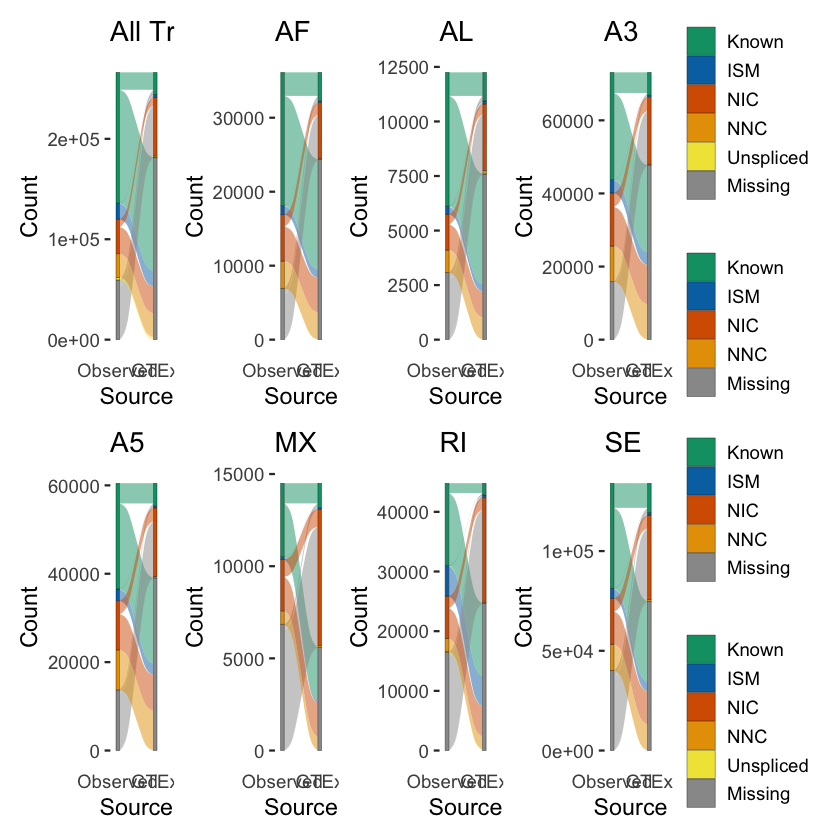

In [14]:
df <- transcripts %>% 
  filter(source != 'v40' & source != 'v29') %>% 
  select(transcript_id, source, ic_novelty) %>% distinct() %>%
  mutate(across(where(is.factor), as.character)) %>%
  pivot_wider(names_from = source, values_from = ic_novelty, values_fill = 'Missing') %>%
  group_by(lapa, gtex) %>% summarise(n = n()) %>% as.data.frame()

# relabel
df$lapa <- factor(df$lapa, levels =c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced', 'Missing'))
df$gtex <- factor(df$gtex, levels =c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced', 'Missing'))

cols <- c('Known' = '#009E73', 'ISM' = '#0072B2',
          'NIC' = '#D55E00', 'NNC' = '#E69F00', 
          'Unspliced' = '#F0E442', 'Missing' = 'gray60')

tot <- ggplot(df, aes(y = n, axis1 = lapa, axis2 = gtex,
                      fill = factor(after_stat(stratum), levels = c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced','Missing')))) + 
  stat_alluvium(geom = "flow", lode.guidance = "forward", width = 0.1) + 
  stat_stratum(aes(fill = factor(after_stat(stratum), levels = c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced','Missing'))), size = 0.1, width = 0.1) + 
  scale_x_discrete(limits = c('Observed', 'GTEx'), expand = rep(0.1, 2)) +
  scale_fill_manual(values = cols) + labs(x = 'Source', y = 'Count', title = 'All Transcripts') +
  theme_alluvial(base_size = 14) + theme(legend.title=element_blank()) 
# ggsave('sankey_plot_all_transcripts.pdf', tot, width = 5, height = 5)

## sankey plot of lapa transcripts and gtex transcripts for each event
sankeyPlot_event <- function(transcripts, lapa_ioe_path, gtex_ioe_path, mapping, event_name){
  lapa <- read.table(lapa_ioe_path, header = T)
  lapa_events <- unlist(lapply(lapa$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
  gtex <- read.table(gtex_ioe_path, header = T)
  gtex_events <- unlist(lapply(gtex$alternative_transcripts, function(x) str_split(x, ',')[[1]]))
  gtex_events_mapping <- subset(mapping, mapping$original_transcript_id %in% gtex_events)
  events <- c(lapa_events, gtex_events_mapping$transcript_id)
  
  
  df <- transcripts %>% 
    filter(source != 'v40' & source != 'v29' & transcript_id %in% events) %>% 
    select(transcript_id, source, ic_novelty) %>% distinct() %>%
    mutate(across(where(is.factor), as.character)) %>%
    pivot_wider(names_from = source, values_from = ic_novelty, values_fill = 'Missing') %>%
    group_by(lapa, gtex) %>% summarise(n = n()) %>% as.data.frame()
  
  df$lapa <- factor(df$lapa, levels =c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced', 'Missing'))
  df$gtex <- factor(df$gtex, levels =c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced', 'Missing'))
  
  cols <- c('Known' = '#009E73', 'ISM' = '#0072B2',
            'NIC' = '#D55E00', 'NNC' = '#E69F00', 
            'Unspliced' = '#F0E442', 'Missing' = 'gray60')
  p <- ggplot(df, aes(y = n, axis1 = lapa, axis2 = gtex,
                      fill = factor(after_stat(stratum), levels = c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced','Missing')))) + 
    stat_alluvium(geom = "flow", lode.guidance = "forward", width = 0.1) + 
    stat_stratum(aes(fill = factor(after_stat(stratum), levels = c('Known', 'ISM', 'NIC', 'NNC', 'Unspliced','Missing'))), size = 0.1, width = 0.1) +
    scale_x_discrete(limits = c('Observed', 'GTEx'), expand = rep(0.1, 2)) +
    scale_fill_manual(values = cols) + labs(x = 'Source', y = 'Count', title = event_name) +
    theme_alluvial(base_size = 14) + theme(legend.title=element_blank()) 
  return(p)
}

gtex_to_cerberus <- read.table(cerb_ids, header = T)
gtex_to_cerberus$transcript_id <- gsub(',','_', gtex_to_cerberus$transcript_id)

AF <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = af, 
                       gtex_ioe_path = g_af, 
                       gtex_to_cerberus, 'AF')

AL <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = al, 
                       gtex_ioe_path = g_al,
                       gtex_to_cerberus, 'AL')

A3 <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = a3,
                       gtex_ioe_path = g_a3,
                       gtex_to_cerberus, 'A3')


A5 <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = a5,
                       gtex_ioe_path = g_a5,
                       gtex_to_cerberus, 'A5')

MX <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = mx,
                       gtex_ioe_path = g_mx,
                       gtex_to_cerberus, 'MX')

RI <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = ri,
                       gtex_ioe_path = g_ri,
                       gtex_to_cerberus, 'RI')

SE <- sankeyPlot_event(transcripts, 
                       lapa_ioe_path = se,
                       gtex_ioe_path = g_se,
                       gtex_to_cerberus, 'SE')

library(patchwork)
p <- (tot + AF + AL + A3 + plot_layout(guides = 'collect', ncol = 4)) / (A5 + MX + RI + SE + plot_layout(guides = 'collect', ncol = 4)) + plot_layout(guides = 'collect')
# ggsave('sankey_plot.pdf', p, width = 16, height = 8)
p

## Overlap between SUPPA and Cerberus

In [9]:
library(dplyr)
library(ggplot2)
library(ggsci)
library(forcats)

In [10]:
## different PSI threshold (0.05/0.95, 0.1/0.9, 0.25/0.75)
summary <- read.csv(lr_meta, sep = '\t', header = TRUE) %>% select(sample, sample_display) %>% distinct()
AF_combined <- read.table(c_s_af_events, sep = '\t', header = T) %>% na.omit() %>%
  dplyr::filter(suppa == TRUE | cerberus == TRUE) %>% mutate(type = ifelse((suppa == TRUE & cerberus == TRUE), 'Consensus', ifelse(suppa == TRUE, 'Only suppa', 'Only cerberus')))
AF_combined <- merge(AF_combined, summary, by = 'sample')


In [11]:
AL_combined <- read.table(c_s_al_events, sep = '\t', header = T) %>% na.omit() %>%
  dplyr::filter(suppa == TRUE | cerberus == TRUE) %>% mutate(type = ifelse((suppa == TRUE & cerberus == TRUE), 'Consensus', ifelse(suppa == TRUE, 'Only suppa', 'Only cerberus')))
AL_combined <- merge(AL_combined, summary, by = 'sample')


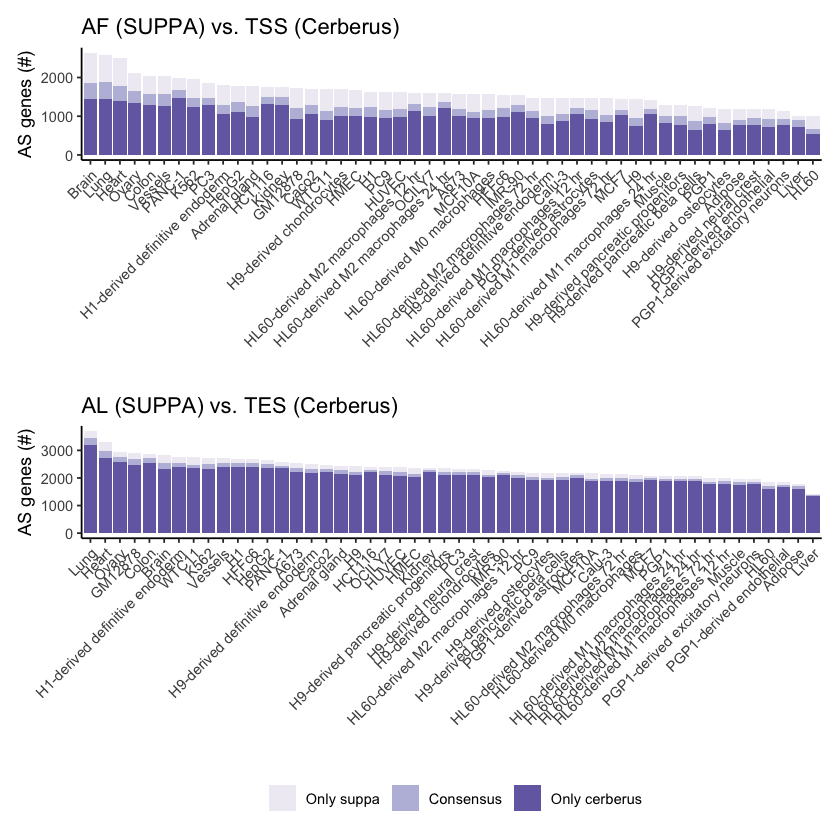

In [12]:
p1 <- ggplot(AF_combined, aes(x = fct_infreq(sample_display), fill=factor(type, levels = c('Only suppa', 'Consensus','Only cerberus')))) + geom_bar() + 
  scale_fill_manual(values = c('Consensus' = '#BCBDDC', 'Only suppa' = '#EFEDF5', 'Only cerberus' = '#756BB1')) + 
  theme_classic() + scale_x_discrete(guide = guide_axis(angle = 45)) + labs(x = '', y = 'AS genes (#)', title = 'AF (SUPPA) vs. TSS (Cerberus)') + theme(legend.title=element_blank(), legend.position="bottom")
p2 <- ggplot(AL_combined, aes(x = fct_infreq(sample_display), fill=factor(type, levels = c('Only suppa', 'Consensus','Only cerberus')))) + geom_bar() + 
  scale_fill_manual(values = c('Consensus' = '#BCBDDC', 'Only suppa' = '#EFEDF5', 'Only cerberus' = '#756BB1')) +
  theme_classic() + scale_x_discrete(guide = guide_axis(angle = 45)) + labs(x = '', y = 'AS genes (#)', title = 'AL (SUPPA) vs. TES (Cerberus)') + theme(legend.title=element_blank(), legend.position="bottom")

library(patchwork)
p <- p1 / p2 + plot_layout(guides = 'collect') & theme(legend.position='bottom')
# ggsave('cerberus_suppa_psi_0.25_0.75.pdf', width = 10, height = 8)
p
